In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import argparse
from read_ggp_run import *
import copy
len_mean = 8
len_cov = 36
len_gaussian = len_mean+len_cov


class Cell:
    def __init__(self, cell_id, parent_id):
        self.parent_id = parent_id
        self.cell_id = cell_id

        self.time = []
        self.number_of_joints = []
        self.line = []
        self.joints = []


# ---------------------------------------------------------------------------------------------------------- #
# Classes to go from the input being chunks of len_mean = 8 + len_cov = 36 to the final correlation function
# ---------------------------------------------------------------------------------------------------------- #
class Gaussian:
    ''' 
    Gaussian (8x8)

    Is constructed from the 8+36 chunk of entires from the input file (strings) and saves the mean and the covariance. 
    In case the entries are empty, mean and covariance are set to None

    Attributes:
        m (np.array((8))): Mean
        C (np.array((8,8))): Covariance

    '''
    def __init__(self, vec):
        try:
            self.m = vec[:8].astype(float)
            cov_vec = vec[8:].astype(float)

            sum_i_9 = [36, 35, 33, 30, 26, 21, 15, 8, 0] #  == [np.sum( np.arange(i,9)) for i in np.arange(1,9)[::1]]

            # cov_vec[sum_i_9[i]: sum_i_9[i-1] ] Equivalent to cov_vec[np.sum( np.arange(i+1,9) ): np.sum( np.arange(i,9))]
            # Also the concatenation with 0s is faster than np.pad
            c = np.array( [ np.concatenate( ([0] *(8-i) , cov_vec[sum_i_9[i]: sum_i_9[i-1] ] ) ) for i in np.arange(1,9)[::-1]])

            self.C = c + np.tril(c.T, -1) 
        except:
            self.m = None
            self.C = None



class Correlation:
    '''
    Calculates the correlation of a given dt

    Adds up the means (m) <z_n> as well as the two point means (mm) <z_n, z_m> = <z_n><z_m> + C, 
    while counting the number of joints (n)

    Attributes:
        dt (float): Time lag
        n (int): Number of joints
        m (np.array((8))): Sum of one point means
        mm (np.array((8,8))): Sum of two point means
        cov (np.array((8,8))): Covariance matrix (None when initialized)
        corr (np.array((8,8))): Correlation matrix, ie the normalized covariance (None when initialized)

    '''
    def __init__(self, dt = 0):
        self.dt = dt
        self.n = 0

        self.mm = np.zeros((8,8))
        self.m = np.zeros((8))
        
        # Those will be set in average and normalize, resprectively 
        self.cov = None
        self.corr = None

    def add(self, joint):
        self.n += 1
        self.m += joint.m

        self.mm += joint.m * joint.m[:,np.newaxis] + joint.C
        # Equivalent to:
        # for i in range(8): for j in range(8): self.mm[i,j] += joint.m[i] * joint.m[j] + joint.C[i,j]


    def average(self):
        # naive implementation but it is not often run
        self.cov = np.zeros((8,8))
        for i in range(8):
                for j in range(8):
                    self.cov[i,j] = self.mm[i,j]/self.n -  self.m[i]/self.n * self.m[j]/self.n

    def normalize(self):
        # naive implementation but it is not often run
        self.corr = np.zeros((8,8))
        if self.n>0:
            for i in range(8):
                for j in range(8):
                    self.corr[i,j] = self.cov[i,j] / np.sqrt(self.cov[i,i] * self.cov[j,j])


class Correlation_function:
    '''
    Represents a Correlation function

    Constructed from a list of correlation instances, that may or may not be averaged and normalized

    Attributes:
        dts (np.array(N)):  List of time lags
        n (np.array(N)): List of number of joints
        corrs (np.array((8,8,N))): Sum of one point means
    '''
    def __init__(self, correlations):
        dts = []
        corrs = [] 
        n = []
        for c in copy.deepcopy(correlations):
            # (re-) calculate the correlation 
            c.average()
            c.normalize()
            
            dts.append(c.dt)
            corrs.append(c.corr)
            n.append(c.n)

        # save as numpy arrays
        self.dts = np.array(dts)
        self.n = np.array(n)
        self.corrs = np.stack(corrs, axis=2)

    def get(self, zi, zj):
        mapping = {z:i for i, z in enumerate(["x(t+dt)", "g(t+dt)", "l(t+dt)", "q(t+dt)", "x(t)", "g(t)", "l(t)", "q(t)"])}
        return self.corrs[mapping[zi],mapping[zj]]





def file2correlation_function(filename, dts, tol, return_isjoint=False, filter_func=lambda a,b,c,d: True): 
    # Variables that will be returned
    correlations = []
    time_points = []
    cell_ids = []
    if return_isjoint:
        is_joint =  np.zeros((0,))

    # initialize a few variable 
    last_cell = ""
    count_cells = 0 
    skip = True
    line_number = 0
    
    correlations = [Correlation(dt=dt) for dt in dts]
    
    with open(filename,'r') as fin:
        for _, line in enumerate(fin):
            if not skip:
                line_splitted = line.strip('\n').split(',')
                cell_id = line_splitted[0]
                time = float(line_splitted[2])
                chunks =  np.reshape(line_splitted[3:], (-1,len_gaussian))
                joints_vecs = [Gaussian(c) if c[0]!='' else None for c in chunks]
                for j, joint in enumerate(joints_vecs):
                    if joint!=None:                        
                        idx = np.argwhere(np.isclose(dts, time_points[j] - time, atol=tol))
                        if len(idx)>0:
                            correlations[idx[0,0]].add(joint)

                        if return_isjoint:
                            is_joint[line_number, j] = 1
                            
                if cell_id != last_cell:
                    print("\rNumber of cells processed: ", count_cells, end='')  
                    count_cells += 1

                last_cell = cell_id
                line_number+=1

            if line.startswith('cell_id'):
                skip = False    
                line_splitted = line.strip('\n').split(',')[3:]
                for entry in line_splitted:
                    if entry != '':
                        cell_ids.append(int(entry.split('_')[0]))
                        time_points.append(float(entry.split('_')[1]))
                if return_isjoint:
                    is_joint = np.zeros((len(time_points), len(time_points)), dtype=int)
    if return_isjoint:
        return Correlation_function(correlations), pd.DataFrame(is_joint, columns = cell_ids, index = cell_ids)
    else:
        return Correlation_function(correlations)




def file2cells(filename, save_joints=False):
    cell_list = []
    time_points = []
    last_cell = ""
    skip = True
    with open(filename,'r') as fin:
        for i, line in enumerate(fin):
            if not skip:
                line_splitted = line.strip('\n').split(',')
                if line_splitted[0] != last_cell:
                    new_cell = Cell(line_splitted[0], line_splitted[1])
                    cell_list.append(new_cell)
                cell_list[-1].time.append(line_splitted[2])
                cell_list[-1].number_of_joints.append( int((len(line_splitted)-3)/(len_gaussian)) ) 
                if save_joints:
                    joints_vecs =  np.reshape(line_splitted[3:], (-1,len_gaussian) )
                    cell_list[-1].joints.append( [Gaussian(joints_vec) for joints_vec in joints_vecs] )

                last_cell = line_splitted[0]

            if line.startswith('cell_id'):
                skip = False
                line_splitted = line.strip('\n').split(',')[3:]

                for entry in line_splitted:
                    if entry != '':
                        time_points.append(float(entry.split('_')[-1]))
    return time_points, cell_list

In [ ]:
# %load_ext line_profiler
# %lprun -f file2corr file2corr('../data_3.0/ac_single_lineage_n200_sizer/ac_single_lineage_n200_sizer_0/ac_single_lineage_n200_sizer_0_out/ac_single_lineage_n200_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

In [ ]:
# cov_ac_tree_n3_sizer,     is_joint = file2corr('../data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_joints.csv', np.arange(10, 200, 10), 0.3, return_isjoint=True)
# cov_ac_tree_n10_timer_0,  is_joint = file2corr('../data_3.0/ac_tree_n10_timer/ac_tree_n10_timer_0/ac_tree_n10_timer_0_out/ac_tree_n10_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3, return_isjoint=True)
# cov_ac_tree_n20_timer_0,  is_joint = file2corr('../data_3.0/ac_tree_n20_timer/ac_tree_n20_timer_0/ac_tree_n20_timer_0_out/ac_tree_n20_timer_0_f012345678910_b_joints.csv', np.arange(3, 600, 3), 1, return_isjoint=True)

# cov_ac_tree_n200_timer_0 = file2corr('../data_3.0/ac_tree_n200_timer/ac_tree_n200_timer_0/ac_tree_n200_timer_0_out/ac_tree_n200_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3)
# cov_ac_tree_n500_timer_0 = file2corr('../data_3.0/ac_tree_n500_timer/ac_tree_n500_timer_0/ac_tree_n500_timer_0_out/ac_tree_n500_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3)
# cov_ac_single_lineage_n200_sizer_0 = file2corr('../data_3.0/ac_single_lineage_n200_sizer/ac_single_lineage_n200_sizer_0/ac_single_lineage_n200_sizer_0_out/ac_single_lineage_n200_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

# cov_ac_single_lineage_n500_sizer_0 = file2corr('../data_3.0/ac_single_lineage_n500_sizer/ac_single_lineage_n500_sizer_0/ac_single_lineage_n500_sizer_0_out/ac_single_lineage_n500_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

filename = '../data_3.0/ac_single_lineage_n500_sizer/ac_single_lineage_n500_sizer_0/ac_single_lineage_n500_sizer_0_out/ac_single_lineage_n500_sizer_0_f012345678910_b_joints.csv'

In [ ]:
from treelib import Node, Tree

_,  cells = file2cells(filename)

def show_cell_tree(cells):
    tree = Tree()
    for i in range(len(cells)):
        if int(cells[i].parent_id)>=0:
            tree.create_node(cells[i].cell_id,  cells[i].cell_id, parent=cells[i].parent_id)
        else:
            tree.create_node(cells[i].cell_id,  cells[i].cell_id)
    tree.show()
    

show_cell_tree(cells)

# fig, ax = plt.subplots(figsize=(15,15))
# ax.imshow(is_joint, cmap="binary")

# ticks = []
# ticks_labels = []
# last = ''
# for i, cell_id in enumerate(is_joint.columns):
#     if cell_id != last:
#         ticks_labels.append(cell_id)
#         ticks.append(i)
#         ax.axhline(i, lw=0.1)
#         ax.axvline(i, lw=0.1)

#     last = cell_id 

# ax.set_xticks(ticks)
# ax.set_xticklabels(ticks_labels)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks_labels)
# ax.tick_params(top=True, bottom=False, left=False, right=True,  labelleft=True, labelright=True, 
#                 labeltop=True, labelbottom=False)
# np.shape(is_joint)


In [ ]:
file2correlation_function(filename, np.arange(3,500,3), 0.3)


In [108]:
covs = []

for i in range(3):
    base = 'ac_single_lin_gamma_q_n500_sizer'
    file = ('../data_3.0/'+base+'/'+base+'_{:d}/'+base+'_{:d}_out/'+base+'_{:d}_f012345678910_b_joints.csv').format(i,i,i)
    print(file)
    covs.append(file2correlation_function(file, np.arange(3,500,3), 0.3)
    


../data_3.0/ac_single_lin_gamma_q_n500_sizer/ac_single_lin_gamma_q_n500_sizer_0/ac_single_lin_gamma_q_n500_sizer_0_out/ac_single_lin_gamma_q_n500_sizer_0_f012345678910_b_joints.csv
Number of cells processed:  499../data_3.0/ac_single_lin_gamma_q_n500_sizer/ac_single_lin_gamma_q_n500_sizer_1/ac_single_lin_gamma_q_n500_sizer_1_out/ac_single_lin_gamma_q_n500_sizer_1_f012345678910_b_joints.csv
Number of cells processed:  499../data_3.0/ac_single_lin_gamma_q_n500_sizer/ac_single_lin_gamma_q_n500_sizer_2/ac_single_lin_gamma_q_n500_sizer_2_out/ac_single_lin_gamma_q_n500_sizer_2_f012345678910_b_joints.csv
Number of cells processed:  499

## Correlation

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars


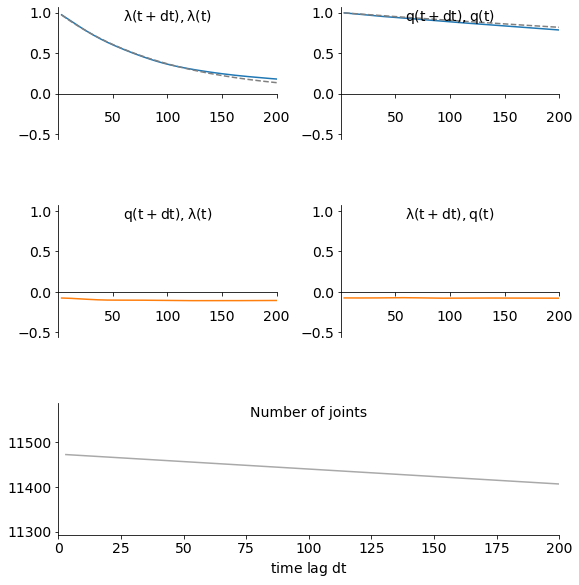

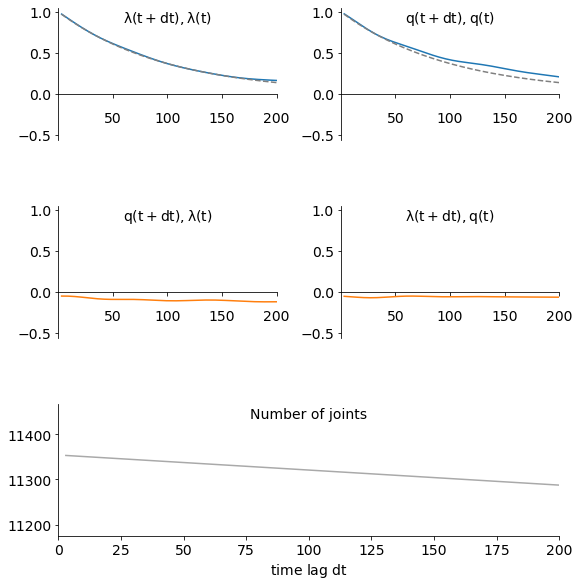

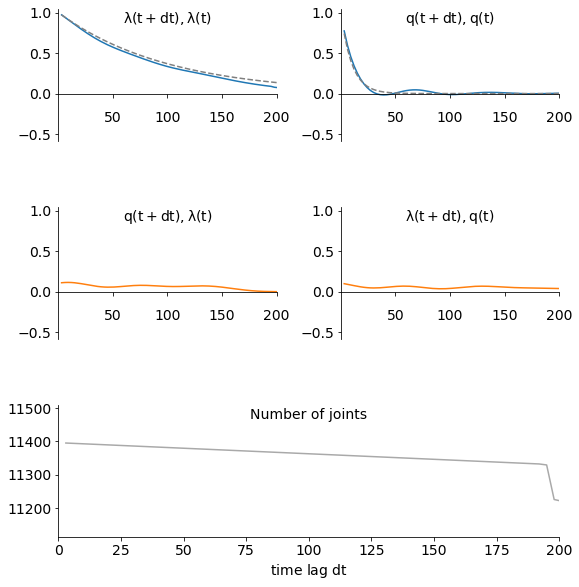

In [110]:
def plot_correlation(cor, gamma_lambda=0.01, gamma_q=0.01, xlim=[0, None]):
    fig, _ = plt.subplots(figsize=(8,8))

    # ax0 = plt.subplot(321) # the figure has 3 row, 2 columns, and this plot is the first plot. 
    # ax1 = plt.subplot(322, sharex=ax0, sharey=ax0)

    # ax2 = plt.subplot(323, sharex=ax0, sharey=ax0)
    # ax3 = plt.subplot(324, sharex=ax0, sharey=ax0)
    # ax4 = plt.subplot(313) 

    ax0 = plt.subplot2grid((3, 2), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
    ax1 = plt.subplot2grid((3, 2), (0, 1), sharex=ax0, sharey=ax0)
    ax2 = plt.subplot2grid((3, 2), (1, 0), sharex=ax0, sharey=ax0)
    ax3 = plt.subplot2grid((3, 2), (1, 1), sharex=ax0, sharey=ax0)
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2) 
    fig.tight_layout(h_pad=4)

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()


    for ax in [ax0, ax1, ax2, ax3]:
        # set the y-spine
        ax.spines['bottom'].set_position('zero')

        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()
        ax.tick_params(axis='x', pad=14)
        # remove first tick
        ax.xaxis.get_major_ticks()[0].set_visible(False)



    ######### Actual plots #########
    ll = cor.get("l(t+dt)", "l(t)")
    ax0.plot(cor.dts, ll, color="tab:blue")

    ax0.set_title(r"$\lambda(t+dt),\lambda(t)$", y=1, pad=-14)
    if gamma_lambda!=None:
        ax0.plot(cor.dts, np.exp(-gamma_lambda*cor.dts), color='grey', ls='--')

    qq = cor.get("q(t+dt)", "q(t)")
    ax1.plot(cor.dts, qq, color="tab:blue")
    ax1.set_title(r"$q(t+dt),q(t)$", y=1, pad=-14)
    if gamma_q!=None:
        ax1.plot(cor.dts, np.exp(-gamma_q*cor.dts), color='grey', ls='--')

    ql = cor.get("q(t+dt)", "l(t)")
    ax2.plot(cor.dts, ql, color="tab:orange")
    ax2.set_title(r"$q(t+dt),\lambda(t)$", y=1, pad=-14)

    lq = cor.get("l(t+dt)", "q(t)")
    ax3.plot(cor.dts, lq, color="tab:orange")
    ax3.set_title(r"$\lambda(t+dt),q(t)$", y=1, pad=-14)
    

    ax4.plot(cor.dts, cor.n, color="darkgrey")
    ax4.set_title("Number of joints", y=1.0, pad=-14)
    ax4.set_xlabel(r"time lag $dt$")

    ns = [n for i,n in enumerate(cor.n) if cor.dts[i]<xlim[1] and cor.dts[i]>xlim[0] ]
    ax4.set_ylim([np.min(ns)*0.99, np.max(ns) *1.01 ])

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.set_xlim(xlim)

for i, cov in enumerate(covs):
    plot_correlation(cor, xlim=[0,200], gamma_q=np.geomspace(0.001, 0.1, 3)[i])


## Marginals

In [ ]:
from read_ggp_run import *

time_points, cells = file2cells('../data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_joints.csv', save_joints=True)
t = np.array(time_points) 

n = len(cells[0].joints[0])

c1 = "darkred"
c2 = "darkgreen"

size = 20
alpha = 0.6
for j in range(1):
    ax = plot_predictions('../data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_prediction.csv', show=False,time_unit=("min", 1) )

    x_0 = [cells[0].joints[j][i].m[4] for i in range(j, n)]
    g_0 = [cells[0].joints[j][i].m[5] for i in range(j, n)]
    l_0 = [cells[0].joints[j][i].m[6] for i in range(j, n)]
    q_0 = [cells[0].joints[j][i].m[7] for i in range(j, n)]

    ax[0].scatter(t[j:len(x_0)+j]- 10, x_0, c=c1, s=size, alpha=alpha, label=r"$P(z_n)=\int dz_{n+m} P(z_{n+m}, z_n)$")
    ax[1].scatter(t[j:len(x_0)+j]- 10, g_0, c=c1, s=size, alpha=alpha)
    ax[2].scatter(t[j:len(x_0)+j]- 10, l_0, c=c1, s=size, alpha=alpha)
    ax[3].scatter(t[j:len(x_0)+j]- 10, q_0, c=c1, s=size, alpha=alpha)


    x_j = [cells[0].joints[j][i].m[0] for i in range(j, n)]
    g_j = [cells[0].joints[j][i].m[1] for i in range(j, n)]
    l_j = [cells[0].joints[j][i].m[2] for i in range(j, n)]
    q_j = [cells[0].joints[j][i].m[3] for i in range(j, n)]

    ax[0].scatter(t[j:len(x_j)+j], x_j, c=c2, s=size, alpha=alpha, label=r"$P(z_{n+m})=\int dz_{n} P(z_{n+m}, z_n)$")
    ax[1].scatter(t[j:len(x_j)+j], g_j, c=c2, s=size, alpha=alpha)
    ax[2].scatter(t[j:len(x_j)+j], l_j, c=c2, s=size, alpha=alpha)
    ax[3].scatter(t[j:len(x_j)+j], q_j, c=c2, s=size, alpha=alpha)

    ax[0].legend(loc='upper left', bbox_to_anchor=(1.1,1))
    plt.show()

In [ ]:
def plot_single_cov(file, cols=["R(x(t+dt)x(t))"], labels=[], gamma = 0.01, gammas=[], 
                    xlim=[None, None], ylim=[0, 1.05], plot_theo=True,  ls=['-'], log=False, n=12):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    data = read_correlation(file, n)
    colors = ['tab:blue', 'tab:green', 'grey']
    for i, col in enumerate(cols):
        if log:
            ax.semilogy(data["dt"].values, data[col].values, color=colors[i], ls='-', label=labels[i])
        else:
            ax.plot(data["dt"].values, data[col].values, color=colors[i], ls='-', label=labels[i])

    if plot_theo:
        ax.plot(data["dt"].values,   np.exp(-data["dt"].values * gamma), 
            label=r"$c^{theo}_{\lambda\lambda}(dt)$, $c^{theo}_{q q}(dt)$", ls='--', color="black") 

    ax.legend()
    
    ax.set_xlabel("$dt$ (min)")
    plt.show()

